In [1]:
# Loading functions
import os
import tarfile
import shutil
import tempfile
import time
import pickle
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset, TciaDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    CropForegroundd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    ResampleToMatchd,
    CropForegroundd,
)
from monai.utils import set_determinism
import torch
import torch.nn.parallel
import torch.distributed as dist

from src.get_data import CustomDataset
import numpy as np
from scipy import ndimage
from types import SimpleNamespace
import wandb
import logging

logging.basicConfig(level=logging.INFO)


In [2]:
# Funciones personalizadas


def fill_holes_3d(mask):
    # Rellenar huecos en la máscara 3D
    filled_mask = ndimage.binary_fill_holes(mask)
    return filled_mask


def expand_mask_3d_td(
    mask, edema, distance_cm_max=0.5, distance_cm_min=0.1, voxel_size=0.1
):
    distance_pixels_max = int(distance_cm_max / voxel_size)
    distance_pixel_min = int(distance_cm_min / voxel_size)

    # Calcular la transformada de distancia
    distance_transform = ndimage.distance_transform_edt(np.logical_not(mask))

    # Crear la nueva máscara alrededor del tumor core
    # expanded_mask_distance = distance_transform >= distance_threshold
    expanded_mask = np.logical_and(
        distance_transform >= distance_pixel_min,
        distance_transform <= distance_pixels_max,
    )

    # Restar la máscara original para obtener solo la región expandida
    exterior_mask = np.logical_and(expanded_mask, np.logical_not(mask))
    # Hacer un AND con el edema para eliminar zonas externas a este
    exterior_mask = np.logical_and(exterior_mask, edema)

    return torch.from_numpy(exterior_mask)

In [3]:
class ConvertToMultiChannel_with_infiltration(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is necrosis
    label 2 is edema
    label 3 is activo
    The possible classes are N (necrosis), E (edema)
    and TA (active).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []

            # label 1 necro
            necro = d[key] == 1
            # result.append(necro)

            # label 2 is Edema
            edema = d[key] == 2
            # result.append(edema)

            # merge labels 3, 4 and 3 to construct activo
            active = torch.logical_or(d[key] == 3, d[key] == 4)
            # result.append(active)

            # Determinar las ROI cercana y lejana al Tumor Core
            tumor_core_mask = np.logical_or(necro, active)

            # Rellenar los huecos en la máscara
            filled_tumor_core = fill_holes_3d(tumor_core_mask)
            # result.append(torch.from_numpy(filled_tumor_core))

            # Definir el tamaño de voxel en centímetros (ajusta según tus datos)
            voxel_size_cm = 0.1

            # Expandir la máscara de 1 cm alrededor del tumor core (N_ROI)
            N_roi = expand_mask_3d_td(
                filled_tumor_core,
                edema=edema,
                distance_cm_max=0.5,
                distance_cm_min=0.1,
                voxel_size=voxel_size_cm,
            )
            result.append(N_roi)

            F_roi = expand_mask_3d_td(
                filled_tumor_core,
                edema=edema,
                distance_cm_max=10,
                distance_cm_min=1,
                voxel_size=voxel_size_cm,
            )
            result.append(F_roi)
            result.append(edema)

            d[key] = torch.stack(result, axis=0).float()
        return d

In [4]:
# Transformaciones
t_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannel_with_infiltration(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        CropForegroundd(
            keys=["image", "label"], source_key="label", margin=[112, 112, 72]
        ),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[112, 112, 72], random_size=False
        ),  # [224, 224, 144]
    ]
)

v_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], allow_missing_keys=True),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannel_with_infiltration(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [5]:
# Creando el modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DATA_DIR = Path('./data/')
SAVE_DIR = "./Dataset"
# SAVE_DIR.mkdir(exist_ok=True, parents=True)
DEVICE = device

#################################
# HIPER PARAMETER CONFIGURATION #
#################################
config_train = SimpleNamespace(
    # network hyperparameters
    init_filters=16,
    dropout_prob=0.2,
    # training hyperparameters
    max_epochs=100,
    lrate=1e-4,
    weight_decay=1e-5,
    batch_size=1,
    # Post
    threshold=0.5,
    # Train type
    use_scaler=False,
    use_autocast=False,
    GT="nroi + froi + edema",
)


def inference(input, model, VAL_AMP=config_train.use_autocast):
    # if config_train.use_autocast:
    #    VAL_AMP = True
    # else:
    #    VAL_AMP = False

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

In [6]:
####################################
# Load DATASET and training modelo #
####################################

dataset_path = "./Dataset/Dataset_30_casos/"

train_set = CustomDataset(
    dataset_path, section="train", transform=t_transform
)  # t_transform
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

im_t = train_set[0]
    # (im_t["image"].shape)
print(im_t["label"].shape)

val_set = CustomDataset(
    dataset_path, section="valid", transform=v_transform
)  # v_transform
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

    # im_v = val_set[0]
    # print(im_v["image"].shape)
    # print(im_v["label"].shape)

    # create a wandb run
    # run = wandb.init(project="SegResNet_UPENN", job_type="train", config=config_train)

    # we pass the config back from W&B
    #config_train = wandb.config

    # Create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],  # 4
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=11,
    out_channels=3,
    dropout_prob=config_train.dropout_prob,
)

model.to(device)

loss_function = DiceLoss(
    smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True
)
optimizer = torch.optim.Adam(
    model.parameters(), config_train.lrate, weight_decay=config_train.weight_decay
)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config_train.max_epochs
)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold=config_train.threshold)]
)

    # use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

Found 30 images and 30 labels.
torch.Size([3, 112, 112, 72])
Found 10 images and 10 labels.


c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [7]:
# Cargar la clave API desde una variable de entorno
logging.info("Logging in WandB")
api_key = os.environ.get("WANDB_API_KEY")
# Iniciar sesión en W&B
wandb.login(key=api_key)

INFO:root:Logging in WandB
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Cecilia/.netrc


True

In [9]:
artifact_dir='Weights'

run = wandb.init()
artifact = run.use_artifact('mlops-team89/SegResNet_UPENN/job-https___github.com_amulet1989_SegResNet_GBMsegmentation.git_train_with_upenn.py:v7', type='job')
artifact_dir = artifact.download()
print(artifact_dir)



wandb:   2 of 2 files downloaded.  


.\artifacts\job-https___github.com_amulet1989_SegResNet_GBMsegmentation.git_train_with_upenn.py-v7


In [13]:
#model.load_state_dict(artifact_dir, map_location=torch.device('cpu'))
model.load_state_dict(torch.load(os.path.join("./Weights", "best_metric_model.pth"), map_location=torch.device('cpu')))
# model.load_state_dict(torch.load(artifact_dir, map_location=torch.device('cpu')))
model.eval()



SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(11, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, 

image shape: torch.Size([11, 240, 240, 155])


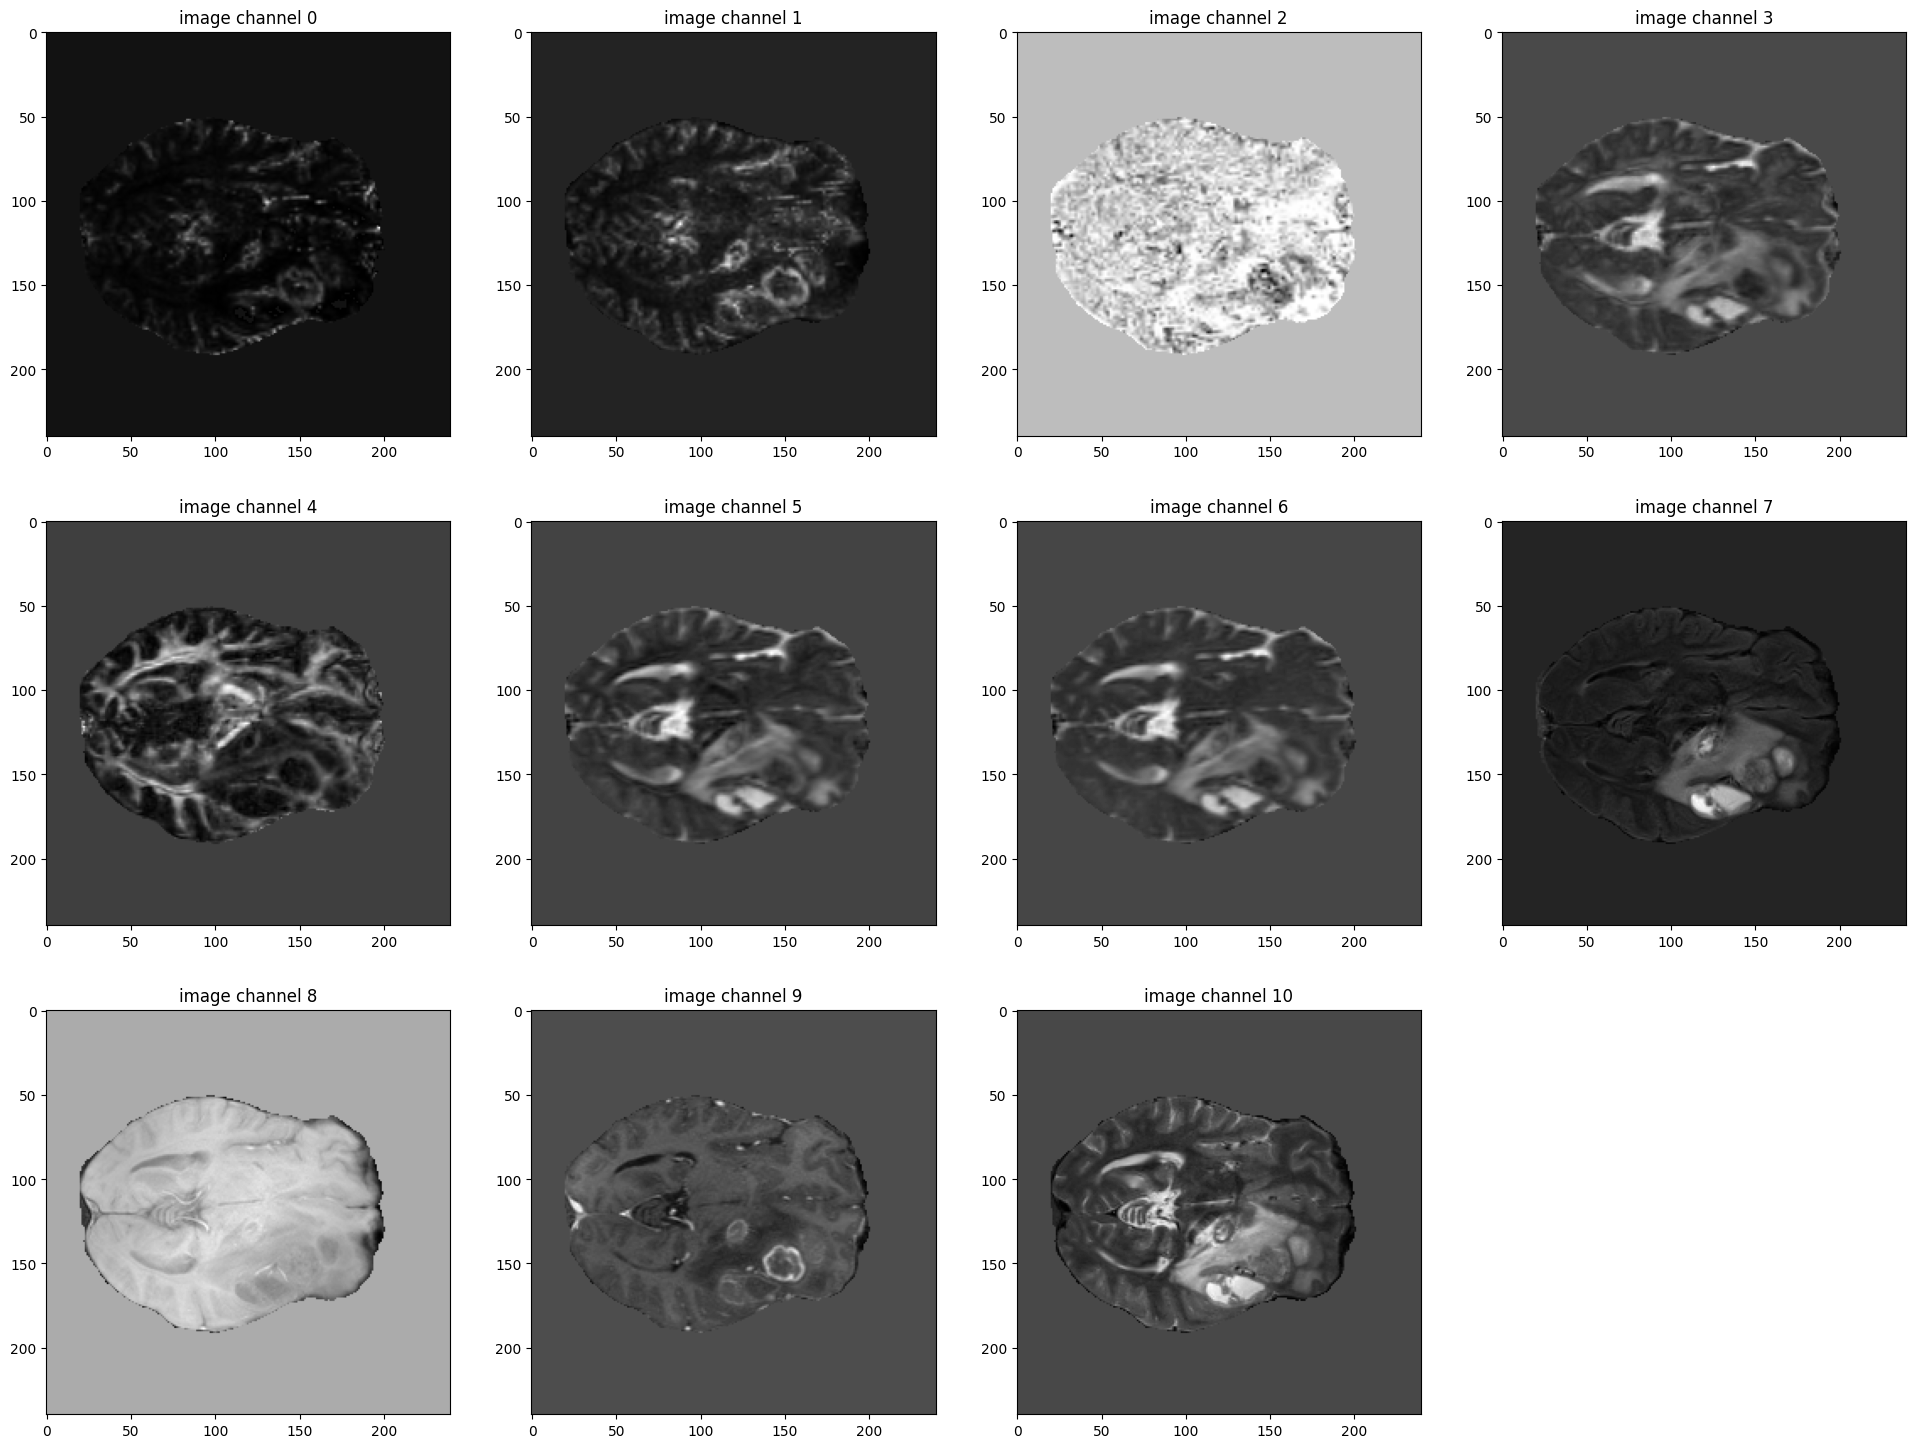

label shape: torch.Size([3, 240, 240, 155])


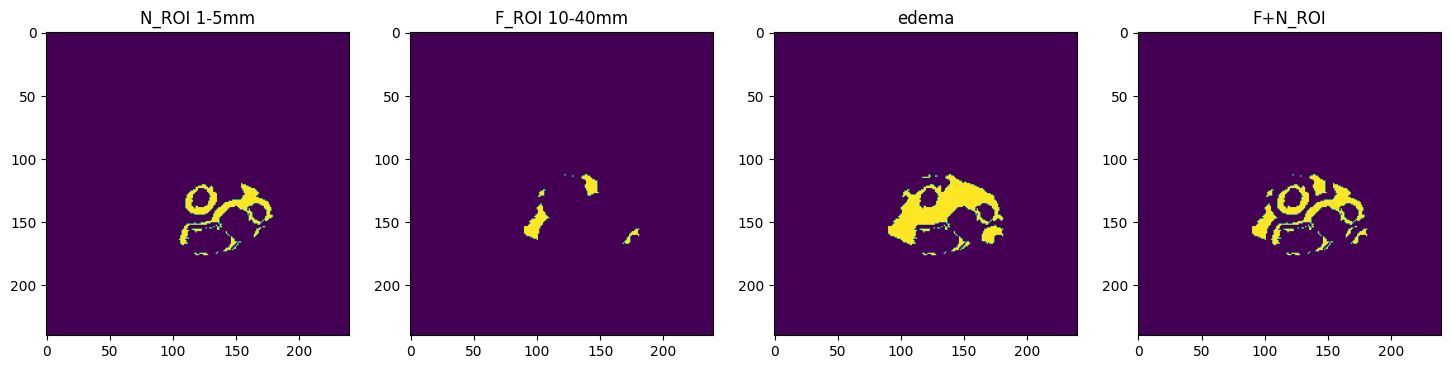

In [23]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
# N_ROI -> hatsa 0.5cm alrededor del TC
# F_ROI -> entre 1 y 4 cm alrededor del TC
val_data_example = val_set[0]
sl=60 #70
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 18))
for i in range(11):
    plt.subplot(3, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
my_title=['N_ROI 1-5mm', 'F_ROI 10-40mm', 'edema', 'F+N_ROI']
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"{my_title[i]}")
    if i<3:
        plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
    else:
        im_show=torch.from_numpy(np.logical_or(val_data_example["label"][0, :, :, sl], val_data_example["label"][1, :, :, sl]))
        plt.imshow((im_show).detach().cpu())

plt.show()

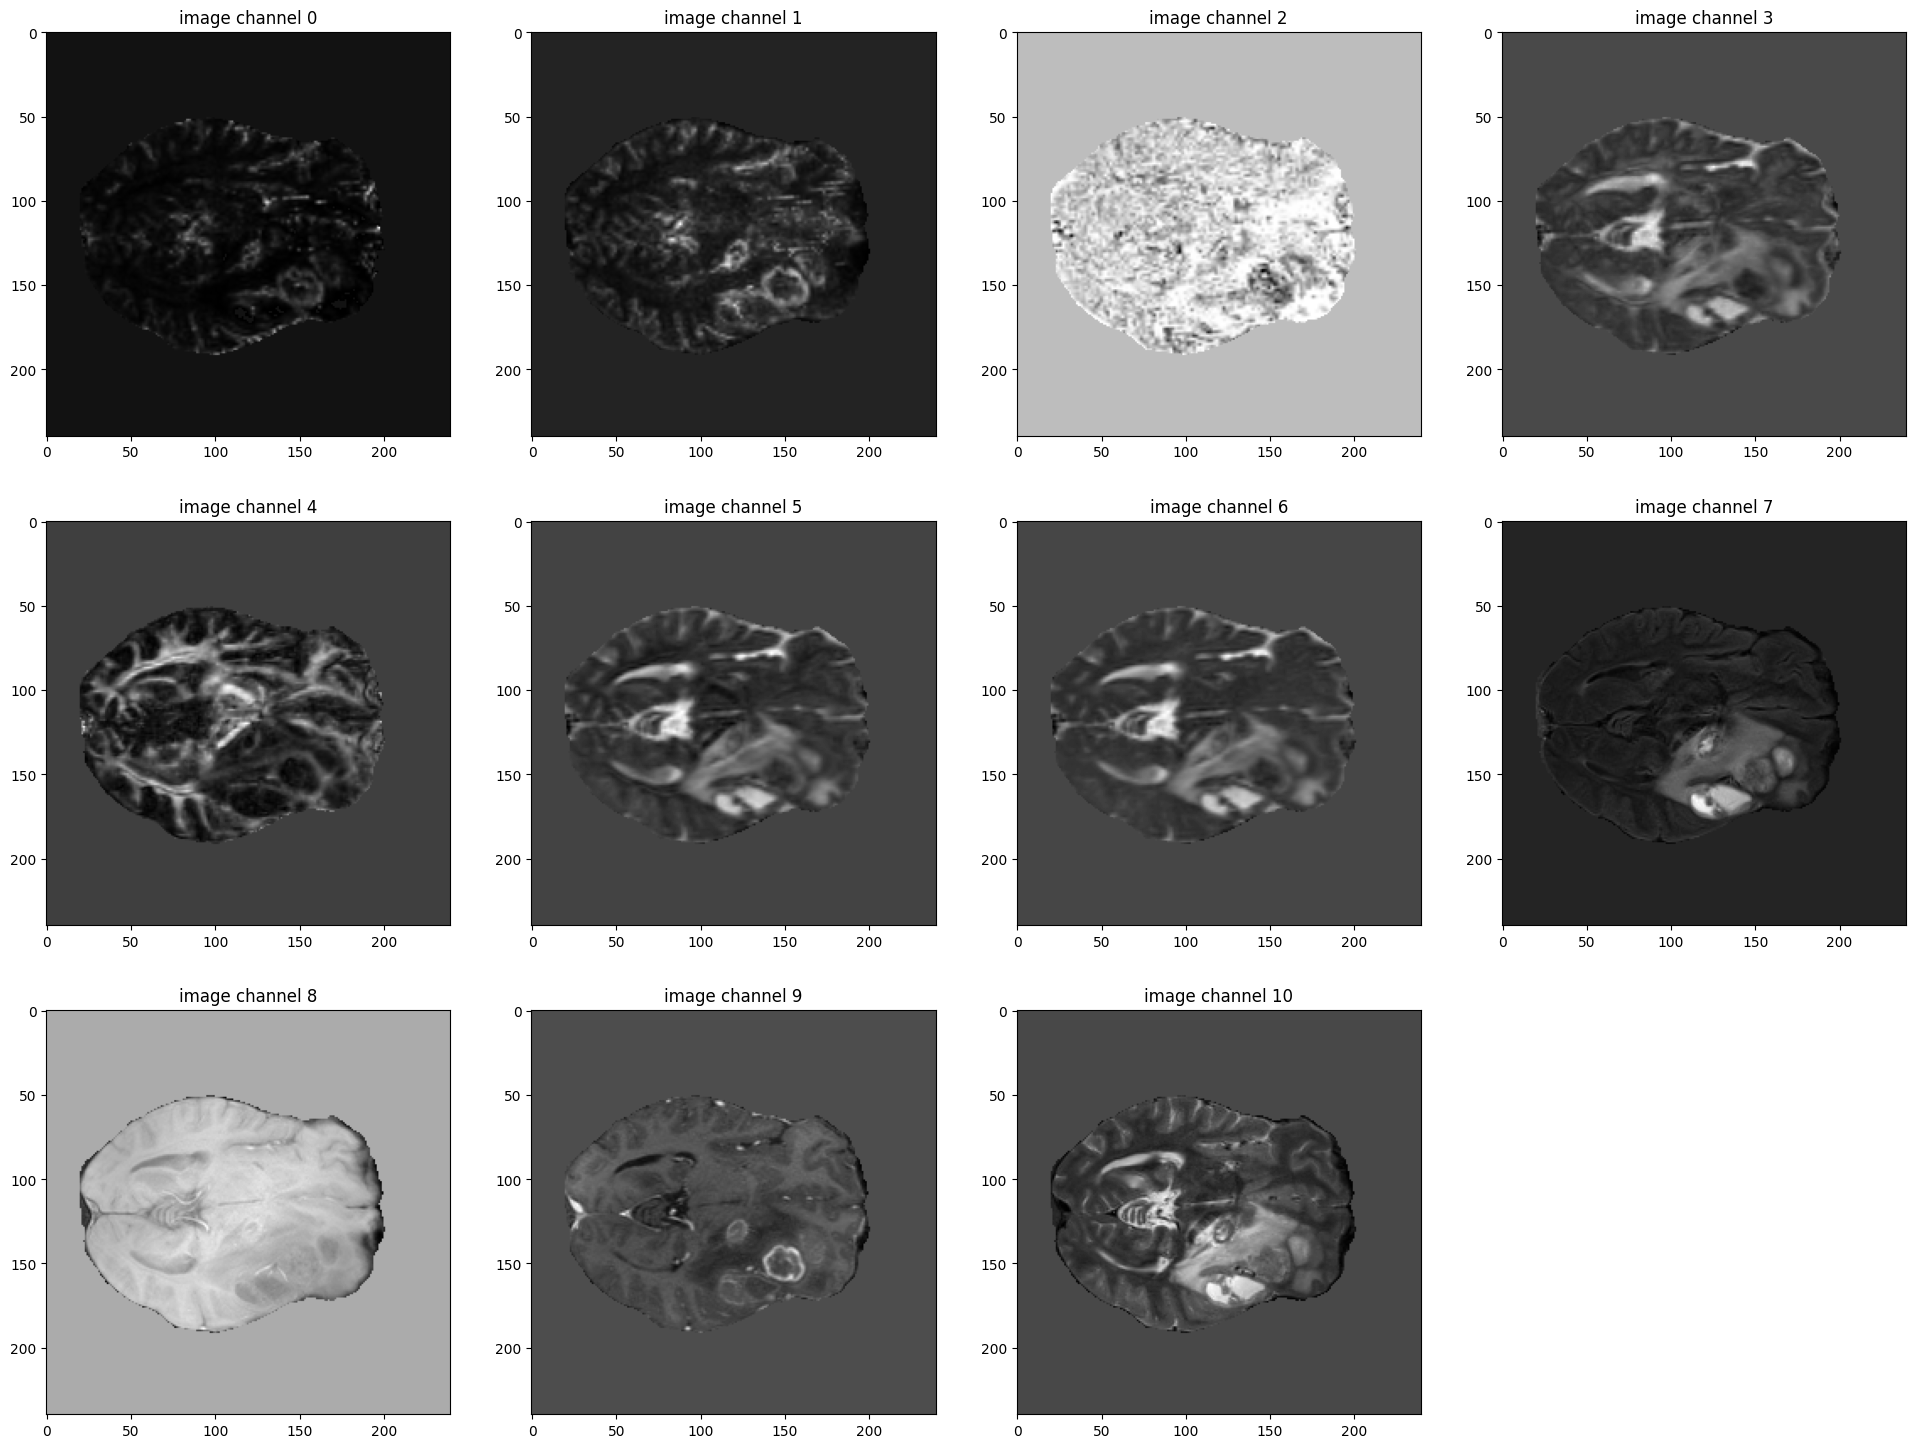

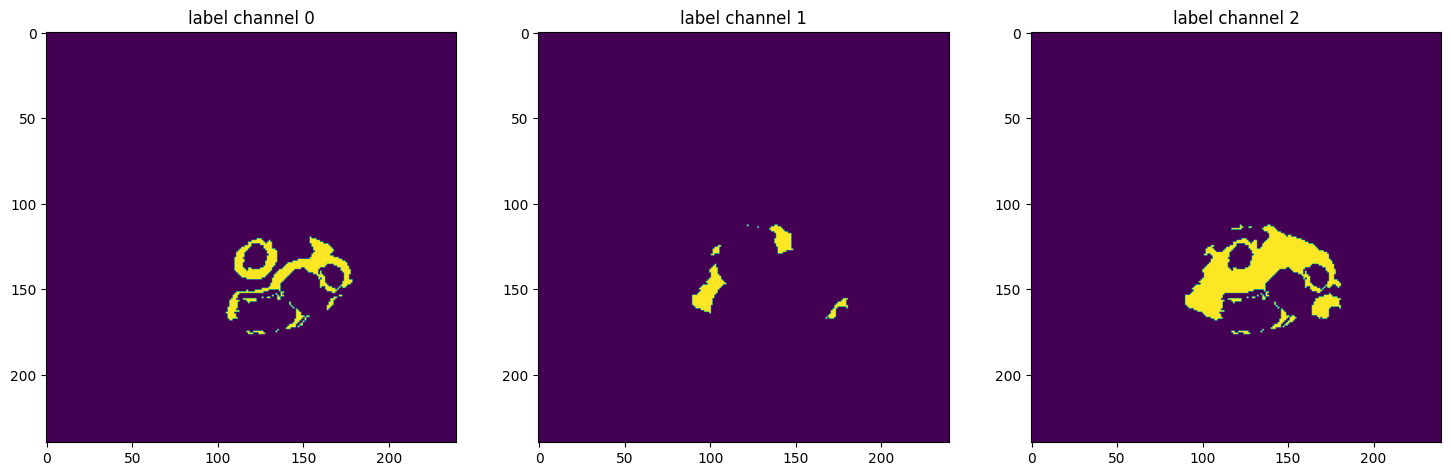

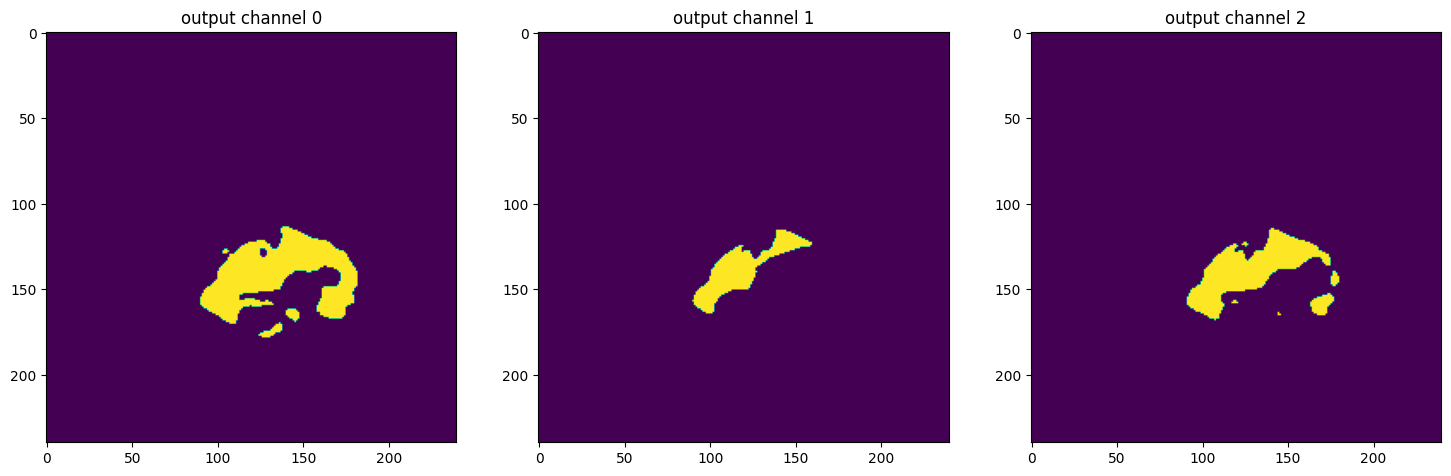

In [24]:
id=0
sl=60
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_set[id]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input, model)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 18))
    for i in range(11):
        plt.subplot(3, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_set[id]["image"][i, :, :, sl].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_set[id]["label"][i, :, :, sl].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, sl].detach().cpu())
    plt.show()